In [1]:
import os
import json
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
from model import Detector
from PIL import Image
from torch.utils.data import DataLoader
from utils import file_format_counter
from dataloader import SARDet
from torchsummary import summary

Data Exploration

In [2]:
data_dir = "/home/hasanmog/CNN-VS-ViT/Datasets/SARDet"
train = os.listdir(os.path.join(data_dir + '/train'))
val = os.listdir(os.path.join(data_dir + '/val'))
len(train) , len(val)

(94493, 10492)

In [3]:
random.seed(50)
random.shuffle(train)
test = train[70000:]
train = train[:70000]
len(train) , len(test)

(70000, 24493)

<PIL.JpegImagePlugin.JpegImageFile image mode=L size=256x256 at 0x7FE9D594A920>


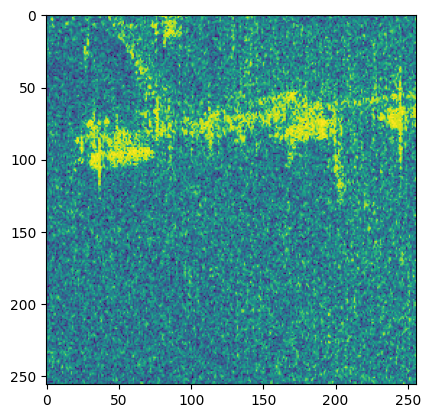

In [4]:
index = 6000
img = Image.open(os.path.join(data_dir+'/train/'+train[index]))
print(img)
plt.imshow(img)

In [5]:
png , jpg ,bmp = file_format_counter(train)         
print(f"train_set: png={png} , jpg={jpg} , bmp={bmp}")
png , jpg ,bmp = file_format_counter(val)         
print(f"val_set: png={png} , jpg={jpg} , bmp={bmp}")
png , jpg ,bmp = file_format_counter(test)         
print(f"test_set: png={png} , jpg={jpg} , bmp={bmp}")      

train_set: png=10893 , jpg=58508 , bmp=599
val_set: png=1834 , jpg=8614 , bmp=44
test_set: png=3771 , jpg=20526 , bmp=196


In [6]:
print(train[0])

0044438.jpg


In [7]:
train_json = os.path.join(data_dir+'/train.json')
val_json = os.path.join(data_dir+'/val.json')

with open(train_json , 'r') as file:
    train_anno = json.load(file)
    
train_anno.keys() , train_anno['images'][0] , train_anno['annotations'][0] , train_anno['categories']

(dict_keys(['images', 'annotations', 'categories']),
 {'file_name': '0028177.jpg', 'height': 512, 'width': 512, 'id': 0},
 {'area': 2394.0,
  'iscrowd': 0,
  'image_id': 0,
  'bbox': [334.0, 188.0, 38.0, 63.0],
  'category_id': 0,
  'id': 0,
  'ignore': 0,
  'segmentation': []},
 [{'id': 0, 'name': 'ship'},
  {'id': 1, 'name': 'aircraft'},
  {'id': 2, 'name': 'car'},
  {'id': 3, 'name': 'tank'},
  {'id': 4, 'name': 'bridge'},
  {'id': 5, 'name': 'harbor'}])

In [8]:
train_set = SARDet(data_dir= data_dir , imgs = train , mode = 'train')
val_set = SARDet(data_dir= data_dir , imgs = val , mode = 'val')
test_set = SARDet(data_dir= data_dir , imgs = test , mode = 'test')
len(train_set) , len(val_set) , len(test_set)

(70000, 10492, 24493)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 8

In [10]:
train_loader = DataLoader(dataset = train_set , batch_size = BATCH_SIZE , shuffle = True)
val_loader = DataLoader(dataset = val_set , batch_size = BATCH_SIZE , shuffle = True)
test_loader = DataLoader(dataset = test_set , batch_size = BATCH_SIZE , shuffle = False)
len(train_loader),len(val_loader),len(test_loader)

(8750, 1312, 3062)

In [14]:
sample = val_set[999]
sample

{'image_tensor': tensor([[[0.0431, 0.0471, 0.0431,  ..., 0.1686, 0.0471, 0.0941],
          [0.0235, 0.0157, 0.0157,  ..., 0.2314, 0.0314, 0.0902],
          [0.0235, 0.0549, 0.0627,  ..., 0.3098, 0.0667, 0.0902],
          ...,
          [0.0275, 0.0235, 0.0275,  ..., 0.1020, 0.1804, 0.3333],
          [0.0196, 0.0471, 0.0627,  ..., 0.1137, 0.1686, 0.3333],
          [0.0353, 0.0510, 0.0392,  ..., 0.1373, 0.1725, 0.2588]],
 
         [[0.0431, 0.0471, 0.0431,  ..., 0.1686, 0.0471, 0.0941],
          [0.0235, 0.0157, 0.0157,  ..., 0.2314, 0.0314, 0.0902],
          [0.0235, 0.0549, 0.0627,  ..., 0.3098, 0.0667, 0.0902],
          ...,
          [0.0275, 0.0235, 0.0275,  ..., 0.1020, 0.1804, 0.3333],
          [0.0196, 0.0471, 0.0627,  ..., 0.1137, 0.1686, 0.3333],
          [0.0353, 0.0510, 0.0392,  ..., 0.1373, 0.1725, 0.2588]],
 
         [[0.0431, 0.0471, 0.0431,  ..., 0.1686, 0.0471, 0.0941],
          [0.0235, 0.0157, 0.0157,  ..., 0.2314, 0.0314, 0.0902],
          [0.0235, 0.054

image size :  (512, 512, 3)


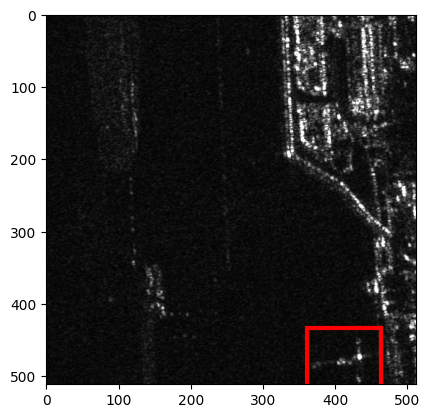

In [12]:
image = sample['image_tensor'].numpy()
image = np.transpose(image , (1 , 2 , 0))
print("image size : " , image.shape)

fig , ax = plt.subplots(1)
ax.imshow(image , cmap='viridis')

for i in range(len(sample['bboxes'])):
    box = sample['bboxes'][i]
    rect = patches.Rectangle((box[0], box[1]), box[2], box[3], linewidth=3, edgecolor='r', facecolor='none')
    plt.gca().add_patch(rect)
    
plt.show()

In [13]:
model = Detector()
summary(model , input_size=(3,256 , 256))

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [ ]:
input_array = np.random.randint(0, 1, (800, 800, 3))  # Generate a random 800x800 image with 3 channels (RGB)
input_tensor = torch.from_numpy(input_array).float()  # Convert to float tensor
print(input_tensor.shape)
input_tensor = input_tensor.permute(2, 0, 1).unsqueeze(0)  

input_tensor = input_tensor.to(device)
# Pass the input tensor through the model
outputs = model(input_tensor)  # Ensure model is in evaluation mode if not training: model.eval()
outputs[: , : , 0 , 0] , outputs.shape

In [ ]:
from postprocessing import convert_to_mins_maxes , non_max_suppression , process_boxes
from model import decode_outputs

boxes , object , class_scores = decode_outputs(outputs) 
boxes = boxes.reshape(-1, 4)
class_scores = class_scores.reshape(-1, 6)
print(boxes.shape)
print(class_scores.shape)
assert boxes.shape[0] == class_scores.shape[0], "Mismatch in bounding boxes and class scores counts"
picked_boxes, picked_scores, picked_classes = non_max_suppression(boxes,class_scores)
len(picked_boxes) , len(picked_scores) , len(picked_classes)